In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample-submit/submit_last.csv
/kaggle/input/garbage-class-data/Garbage classification/TEST/organic/Organic_770.jpg
/kaggle/input/garbage-class-data/Garbage classification/TEST/organic/Organic_677.jpg
/kaggle/input/garbage-class-data/Garbage classification/TEST/organic/Organic_1042.jpg
/kaggle/input/garbage-class-data/Garbage classification/TEST/organic/Organic_75.jpg
/kaggle/input/garbage-class-data/Garbage classification/TEST/organic/Organic_107.jpg
/kaggle/input/garbage-class-data/Garbage classification/TEST/organic/Organic_1006.jpg
/kaggle/input/garbage-class-data/Garbage classification/TEST/organic/Organic_111.jpg
/kaggle/input/garbage-class-data/Garbage classification/TEST/organic/Organic_681.jpg
/kaggle/input/garbage-class-data/Garbage classification/TEST/organic/Organic_536.jpg
/kaggle/input/garbage-class-data/Garbage classification/TEST/organic/Organic_1018.jpg
/kaggle/input/garbage-class-data/Garbage classification/TEST/organic/Organic_849.jpg
/kaggle/input/garba

In [3]:
import numpy as np
import torch
import pickle

from pathlib import Path
from PIL import Image
from tqdm import tqdm, tqdm_notebook

import torch.nn as nn

from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
from sklearn.preprocessing import LabelEncoder


from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [4]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
torch.cuda.empty_cache()

In [5]:
!nvidia-smi
torch.cuda.is_available()

Tue May 25 19:26:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

Для более точного тестирования разных моедлей и повторного воспроизведения их результатов определим функуию фикисрования сидов.

In [6]:
import random
import os

def set_seed(seed):

  # Устанавливаем начальное число для генерации простых чисел
  torch.manual_seed(seed)

  # Устанавливаем начальное число для генерации простых чисел
#   torch.use_deterministic_algorithms(True)

  # Устанавливаем начальное число для генерации простых чисел
  torch.backends.cudnn.deterministic = True

  # Устанавливаем начальное число для генерации простых чисел
  torch.backends.cudnn.baenchmark = False

  # Устанавливаем начальное число для генерации простых чисел
  np.random.seed(seed)

  # Устанавливаем начальное число для генерации простых чисел
  random.seed(seed)

  # Значение os.environ известно как объект мэппинга (сопоставления), 
  # который работает со словарем переменных пользовательской среды. 
  os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [7]:
# разные режимы датасета 
DATA_MODES = ['train', 'test', 'val']

# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

# работаем на видеокарте
DEVICE = torch.device("cuda")

In [8]:
class WasteDataset(Dataset):
    """ 
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """

    def __init__(self, files, mode):
      super().__init__()
      self.files = sorted(files)
      self.mode = mode

      if self.mode not in DATA_MODES:
        print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
        raise NameError

      self.len_ = len(self.files)
      
      self.label_encoder = LabelEncoder()

      if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_
    
    def load_sample(self, file):
      """ Загрузка изображения """
      image = Image.open(file).convert('RGB')
      image.load()
      return image

    def _prepare_sample(self, image):
        """ Корретировка размера изображения """
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image

    def __getitem__(self, index):
      transform = {
          'train': transforms.Compose([
#               transforms.RandomRotation(40),
              transforms.RandomVerticalFlip(),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ]),
          'test': transforms.Compose([
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
      }

      x = self.load_sample(self.files[index])
      x = self._prepare_sample(x)

      if self.mode == 'train':
        x = transform['train'](x)
      else:
        x = transform['test'](x)

      if self.mode == 'test':
        return x
      else:
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """ Imshow для тензоров """
  
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)

    if title is not None:
        plt.title(title)
    plt_ax.grid(False)

In [10]:
TRAIN_DIR = Path('../input/garbage-class-data/Garbage classification/TRAIN')
TEST_DIR = Path('../input/garbage-class-data/Garbage classification/TEST')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

NEW DATA

In [11]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)


In [12]:
train_dataset = WasteDataset(train_files, mode='train')

val_dataset = WasteDataset(val_files, mode='val')

test_dataset = WasteDataset(test_files, mode='test')

In [13]:
train_dataset.len_

3493

In [14]:
val_dataset.len_

1165

In [15]:
test_dataset.len_

524

Посмотрим, что лежит в тестовом датасете

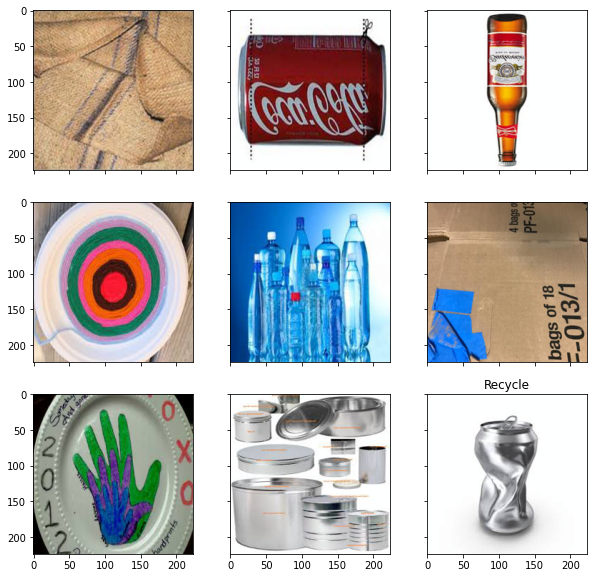

In [17]:
random_characters = int(np.random.uniform(0, 1000))
im_train, label = val_dataset[random_characters]
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(10, 10), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1406))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Построение нейросети
Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и дальнейшего эксперементирования с learning rate

Описание слоев:

    размерность входа: 3x224x224
    размерности после слоя: 8x111x111
    16x54x54
    32x26x26
    64x12x12
    выход: 96x5x5


In [18]:
def fit_epoch(model, train_loader, criterion, optimazer, scheduler):
  """ Обучение модели  c настройкой весов"""
  
  scheduler.step()
  running_loss = 0.0
  running_corrects = 0
  processed_data = 0

  # Итерация по бачам
  for inputs, labels in train_loader:
    # Обертка переменных для забуска на видео карте
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    # Инициализируем градиенты параметров
    optimazer.zero_grad()

    # forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # backward pass и оптимизация
    loss.backward()
    optimazer.step()
    preds = torch.argmax(outputs, 1)

    # Подсчет статистики 
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_data += inputs.size(0)

  train_loss = running_loss / processed_data
  train_acc = running_corrects.cpu().numpy() / processed_data

  return train_loss, train_acc

In [19]:
def eval_epoch(model, val_loader, criterion):
  """ Этап валидации для промежуточной оценки качества обучения модели"""

  model.eval()
  running_loss = 0.0
  running_corrects = 0
  processed_size = 0

  # Итерация по бачам
  for inputs, labels in val_loader:
      # Обертка переменных для забуска на видео карте
      inputs = inputs.to(DEVICE)
      labels = labels.to(DEVICE)

      # Проходимся по всей моедли, но уже не корректируем веса
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, 1)

      # Подсчет статистики 
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
      processed_size += inputs.size(0)

  val_loss = running_loss / processed_size
  val_acc = running_corrects.double() / processed_size

  return val_loss, val_acc
      

In [20]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
  """ Обучение модели на батчах с определенным количеством эпох """

  # Разделение множества данных на батчи
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  best_model_wts = model.state_dict()
  best_acc = 0.0

  history = []
  log_template =  "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
  val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

  with tqdm(desc="epoch", total=epochs) as pbar_outer:
    # Оптимизационный алгоритм (подсчет и изменения градиента)
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#     optimizer = torch.optim.Adam(params=[
#             {"params": model.fc.parameters()},
#             {"params": model.layer4.parameters(), "lr": 1e-4},
#             {"params": model.layer3.parameters(), "lr": 1e-4},
#             {"params": model.layer2.parameters(), "lr": 1e-4},
#             {"params": model.layer1.parameters(), "lr": 1e-4},
#         ],
#         lr=1e-3
#     )

    optimizer = torch.optim.Adam(params=[
          {"params": model.fc.parameters()},
          {"params": model.layer4.parameters(), "lr": 1e-4},
          {"params": model.layer3.parameters(), "lr": 1e-4}
      ]
    )
    
    # Метод вычисления точности результата (доствоверности), оптимизируемая функция
    criterion = nn.CrossEntropyLoss()

    # Уменьшение шага градиента в 10 раз
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=4, gamma=0.1)

    # Итерируемся по эпохам 
    for epoch in range(epochs):
      # Обучение
#       if epoch == (epochs // 2):
#             model.unfreeze()
        
      train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, \
                                        exp_lr_scheduler)

      # Проверка
      val_loss, val_acc = eval_epoch(model, val_loader, criterion)
      
      # Если достиглось лучшее качество, то запомним веса модели
      if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = model.state_dict()

      history.append((train_loss, train_acc, val_loss, val_acc))
      pbar_outer.update(1)
      tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, \
                                     v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
  print(f'Best val accurancy: {best_acc}')
  model.load_state_dict(best_model_wts)

  return model, history

In [21]:
def predict(model, test_loader):
  """ Тестирование и измерение точности модели """

  with torch.no_grad():
    logits = []

    for inputs in test_loader:
      inputs = inputs.to(DEVICE)
      model.eval()
      outputs = model(inputs).cpu()
      logits.append(outputs)

  probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
  return probs


**ResNet50**

In [22]:
model_res50 = models.wide_resnet50_2(pretrained=True)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

In [53]:
model_res50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [ ]:
!nvidia-smi
torch.cuda.is_available()

In [ ]:
torch.cuda.empty_cache()

Изменение learning rate: Можно не замораживать все первые слои, а делать так, чтобы шаг градиента на них был меньше. Интерфейс оптимизатора позволяет это делать.

In [51]:
n_classes = len(np.unique(train_val_labels))
num_features = 2048
# layears_freeze = 5

# for param in model_res50.parameters():
#     param.requires_grad = False
    
model_res50.fc = nn.Linear(num_features, n_classes)

model_res50 = model_res50.to(DEVICE)

In [23]:
model, history = train(train_dataset, val_dataset, model=model_res50, epochs=10, batch_size=16)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
epoch:  10%|█         | 1/10 [01:50<16:37, 110.79s/it]


Epoch 001 train_loss: 0.7076   val_loss 0.6359 train_acc 0.7176 val_acc 0.7384


epoch:  20%|██        | 2/10 [03:25<13:31, 101.50s/it]


Epoch 002 train_loss: 0.5854   val_loss 0.5403 train_acc 0.7464 val_acc 0.7782


epoch:  30%|███       | 3/10 [05:00<11:30, 98.58s/it] 


Epoch 003 train_loss: 0.5200   val_loss 0.5001 train_acc 0.7857 val_acc 0.7890


epoch:  40%|████      | 4/10 [06:37<09:47, 97.90s/it]


Epoch 004 train_loss: 0.4865   val_loss 0.4704 train_acc 0.8123 val_acc 0.7990


epoch:  50%|█████     | 5/10 [08:12<08:04, 96.90s/it]


Epoch 005 train_loss: 0.4677   val_loss 0.4668 train_acc 0.8173 val_acc 0.8173


epoch:  60%|██████    | 6/10 [09:48<06:26, 96.60s/it]


Epoch 006 train_loss: 0.4625   val_loss 0.4648 train_acc 0.8270 val_acc 0.8198


epoch:  70%|███████   | 7/10 [11:24<04:49, 96.36s/it]


Epoch 007 train_loss: 0.4604   val_loss 0.4625 train_acc 0.8223 val_acc 0.8198


epoch:  80%|████████  | 8/10 [12:59<03:11, 95.97s/it]


Epoch 008 train_loss: 0.4629   val_loss 0.4605 train_acc 0.8195 val_acc 0.8223


epoch:  90%|█████████ | 9/10 [14:34<01:35, 95.57s/it]


Epoch 009 train_loss: 0.4511   val_loss 0.4581 train_acc 0.8281 val_acc 0.8231


epoch: 100%|██████████| 10/10 [16:09<00:00, 96.93s/it]


Epoch 010 train_loss: 0.4523   val_loss 0.4578 train_acc 0.8286 val_acc 0.8231
Best val accurancy: 0.8230897009966778


In [47]:
model0, history0 = train(train_dataset, val_dataset, model=model_res50, epochs=10, batch_size=16)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
epoch:   5%|▌         | 1/20 [01:39<31:32, 99.60s/it]


Epoch 001 train_loss: 0.4518   val_loss 0.4406 train_acc 0.8270 val_acc 0.8322


epoch:  10%|█         | 2/20 [03:14<28:58, 96.59s/it]


Epoch 002 train_loss: 0.4337   val_loss 0.4387 train_acc 0.8375 val_acc 0.8231


epoch:  15%|█▌        | 3/20 [04:49<27:14, 96.16s/it]


Epoch 003 train_loss: 0.4190   val_loss 0.4202 train_acc 0.8430 val_acc 0.8414


epoch:  20%|██        | 4/20 [06:26<25:43, 96.44s/it]


Epoch 004 train_loss: 0.4114   val_loss 0.4095 train_acc 0.8414 val_acc 0.8488


epoch:  25%|██▌       | 5/20 [08:02<24:03, 96.24s/it]


Epoch 005 train_loss: 0.3973   val_loss 0.4087 train_acc 0.8538 val_acc 0.8488


epoch:  30%|███       | 6/20 [09:38<22:25, 96.09s/it]


Epoch 006 train_loss: 0.3963   val_loss 0.4082 train_acc 0.8541 val_acc 0.8488


epoch:  35%|███▌      | 7/20 [11:14<20:48, 96.07s/it]


Epoch 007 train_loss: 0.3922   val_loss 0.4074 train_acc 0.8569 val_acc 0.8488


epoch:  40%|████      | 8/20 [12:50<19:12, 96.03s/it]


Epoch 008 train_loss: 0.3912   val_loss 0.4067 train_acc 0.8538 val_acc 0.8505


epoch:  45%|████▌     | 9/20 [14:29<17:47, 97.06s/it]


Epoch 009 train_loss: 0.3929   val_loss 0.4058 train_acc 0.8535 val_acc 0.8488


epoch:  50%|█████     | 10/20 [16:08<16:16, 97.62s/it]


Epoch 010 train_loss: 0.3953   val_loss 0.4057 train_acc 0.8519 val_acc 0.8488


epoch:  55%|█████▌    | 11/20 [17:47<14:42, 98.05s/it]


Epoch 011 train_loss: 0.3904   val_loss 0.4056 train_acc 0.8577 val_acc 0.8497


epoch:  60%|██████    | 12/20 [19:26<13:07, 98.40s/it]


Epoch 012 train_loss: 0.3963   val_loss 0.4055 train_acc 0.8511 val_acc 0.8497


epoch:  65%|██████▌   | 13/20 [21:06<11:32, 98.92s/it]


Epoch 013 train_loss: 0.3912   val_loss 0.4055 train_acc 0.8558 val_acc 0.8497


epoch:  70%|███████   | 14/20 [22:45<09:53, 98.96s/it]


Epoch 014 train_loss: 0.3889   val_loss 0.4054 train_acc 0.8577 val_acc 0.8505


epoch:  75%|███████▌  | 15/20 [24:25<08:15, 99.14s/it]


Epoch 015 train_loss: 0.3898   val_loss 0.4054 train_acc 0.8530 val_acc 0.8505


epoch:  75%|███████▌  | 15/20 [24:47<08:15, 99.17s/it]


KeyboardInterrupt: 

In [57]:
model_1, history_1 = train(train_dataset, val_dataset, model=model_res50, epochs=10, batch_size=16)

epoch:   0%|          | 0/10 [00:17<?, ?it/s]


KeyboardInterrupt: 

In [23]:
model_mixed = model_res50

In [24]:
model_mixed = model_mixed.to(DEVICE)

In [26]:
n_classes = len(np.unique(train_val_labels))
num_features = 2048

# Выключаем подсчет градиентов для слоев, которые не будем обучать
# for param in model_mixed.parameters:
#     param.requires_grad = False

# for param in model_mixed.layer1[:-layers_to_unfreeze].parameters():
#     param.requires_grad = False

for param in model_mixed.layer1.parameters():
    param.requires_grad = False

for param in model_mixed.layer2.parameters():
    param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 2048

model_mixed.fc = nn.Linear(num_features, n_classes)

model_mixed = model_mixed.to(DEVICE)


In [63]:
model_1, history_1 = train(train_dataset, val_dataset, model=model_mixed, epochs=10, batch_size=16)

epoch:  10%|█         | 1/10 [01:38<14:44, 98.26s/it]


Epoch 001 train_loss: 0.5166   val_loss 0.4788 train_acc 0.7957 val_acc 0.7990


epoch:  20%|██        | 2/10 [03:14<12:56, 97.09s/it]


Epoch 002 train_loss: 0.4027   val_loss 0.4077 train_acc 0.8427 val_acc 0.8364


epoch:  30%|███       | 3/10 [04:51<11:19, 97.08s/it]


Epoch 003 train_loss: 0.3724   val_loss 0.3750 train_acc 0.8599 val_acc 0.8538


epoch:  40%|████      | 4/10 [06:31<09:49, 98.22s/it]


Epoch 004 train_loss: 0.3390   val_loss 0.3793 train_acc 0.8657 val_acc 0.8505


epoch:  50%|█████     | 5/10 [08:07<08:07, 97.41s/it]


Epoch 005 train_loss: 0.3074   val_loss 0.3593 train_acc 0.8862 val_acc 0.8621


epoch:  60%|██████    | 6/10 [09:45<06:30, 97.58s/it]


Epoch 006 train_loss: 0.3032   val_loss 0.3597 train_acc 0.8857 val_acc 0.8621


epoch:  70%|███████   | 7/10 [11:20<04:49, 96.65s/it]


Epoch 007 train_loss: 0.3016   val_loss 0.3584 train_acc 0.8879 val_acc 0.8646


epoch:  80%|████████  | 8/10 [12:54<03:11, 95.92s/it]


Epoch 008 train_loss: 0.2964   val_loss 0.3583 train_acc 0.8901 val_acc 0.8630


epoch:  90%|█████████ | 9/10 [14:29<01:35, 95.50s/it]


Epoch 009 train_loss: 0.2913   val_loss 0.3603 train_acc 0.8882 val_acc 0.8613


epoch: 100%|██████████| 10/10 [16:04<00:00, 96.48s/it]


Epoch 010 train_loss: 0.2855   val_loss 0.3587 train_acc 0.8956 val_acc 0.8605
Best val accurancy: 0.8646179401993356


In [27]:
model_2, history_2 = train(train_dataset, val_dataset, model=model_mixed, epochs=10, batch_size=16)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
epoch:  10%|█         | 1/10 [02:27<22:07, 147.54s/it]


Epoch 001 train_loss: 0.4512   val_loss 0.3081 train_acc 0.8199 val_acc 0.8798


epoch:  20%|██        | 2/10 [04:40<18:30, 138.85s/it]


Epoch 002 train_loss: 0.5132   val_loss 0.4912 train_acc 0.8005 val_acc 0.7931


epoch:  30%|███       | 3/10 [06:50<15:43, 134.83s/it]


Epoch 003 train_loss: 0.3511   val_loss 0.3026 train_acc 0.8674 val_acc 0.8738


epoch:  40%|████      | 4/10 [08:59<13:14, 132.46s/it]


Epoch 004 train_loss: 0.1885   val_loss 0.2736 train_acc 0.9213 val_acc 0.8910


epoch:  50%|█████     | 5/10 [11:09<10:58, 131.62s/it]


Epoch 005 train_loss: 0.1399   val_loss 0.2555 train_acc 0.9485 val_acc 0.8979


epoch:  60%|██████    | 6/10 [13:18<08:43, 130.92s/it]


Epoch 006 train_loss: 0.1018   val_loss 0.2735 train_acc 0.9634 val_acc 0.9004


epoch:  70%|███████   | 7/10 [15:28<06:31, 130.63s/it]


Epoch 007 train_loss: 0.0758   val_loss 0.2678 train_acc 0.9734 val_acc 0.9116


epoch:  80%|████████  | 8/10 [17:40<04:21, 130.93s/it]


Epoch 008 train_loss: 0.0466   val_loss 0.2716 train_acc 0.9845 val_acc 0.9116


epoch:  90%|█████████ | 9/10 [19:51<02:10, 131.00s/it]


Epoch 009 train_loss: 0.0437   val_loss 0.2737 train_acc 0.9863 val_acc 0.9150


epoch: 100%|██████████| 10/10 [22:03<00:00, 132.31s/it]


Epoch 010 train_loss: 0.0329   val_loss 0.2807 train_acc 0.9891 val_acc 0.9159
Best val accurancy: 0.9158798283261802


In [28]:
torch.save(model_2.state_dict(), 'my_resnet1.pth')

In [30]:
model_2.load_state_dict(torch.load('my_resnet1.pth'))

<All keys matched successfully>

In [31]:
loss, acc, val_loss, val_acc = zip(*history_2)

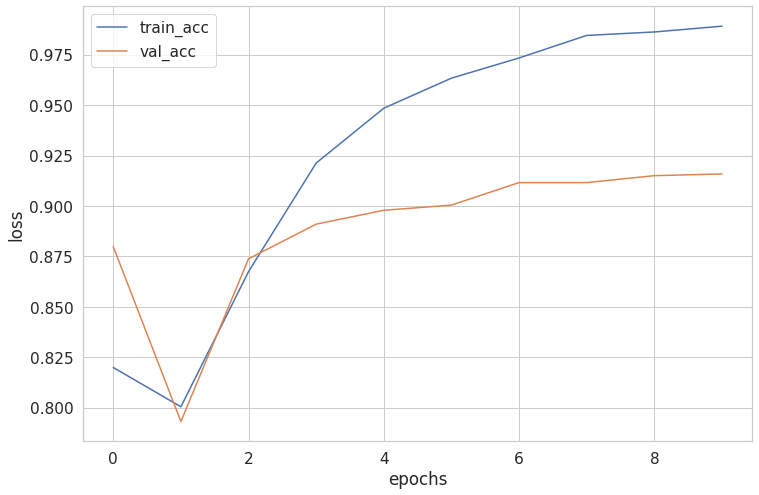

In [32]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

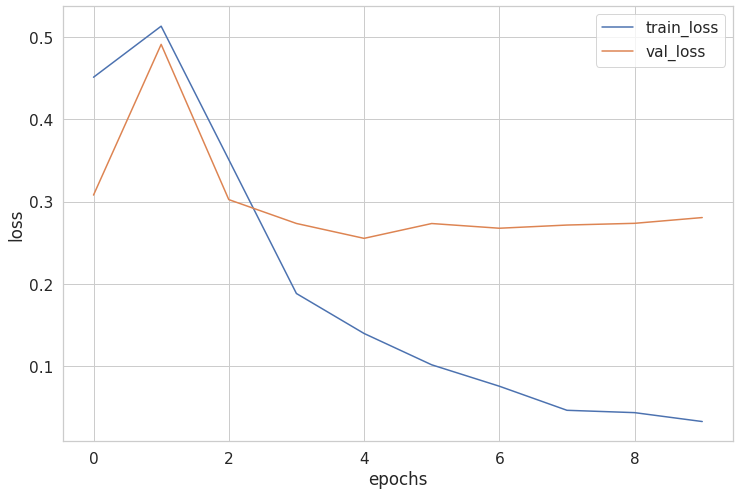

In [33]:
sns.set(style="whitegrid", font_scale=1.4)
plt.figure(figsize=(12, 8))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [34]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [35]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_2, ex_img.unsqueeze(0))

In [37]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_2, imgs)

In [38]:

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [39]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [40]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='macro')


0.9259259259259259

In [41]:

f1_score(actual_labels, y_pred, average='micro')

0.9500000000000001

In [42]:

f1_score(actual_labels, y_pred, average='weighted')

0.95

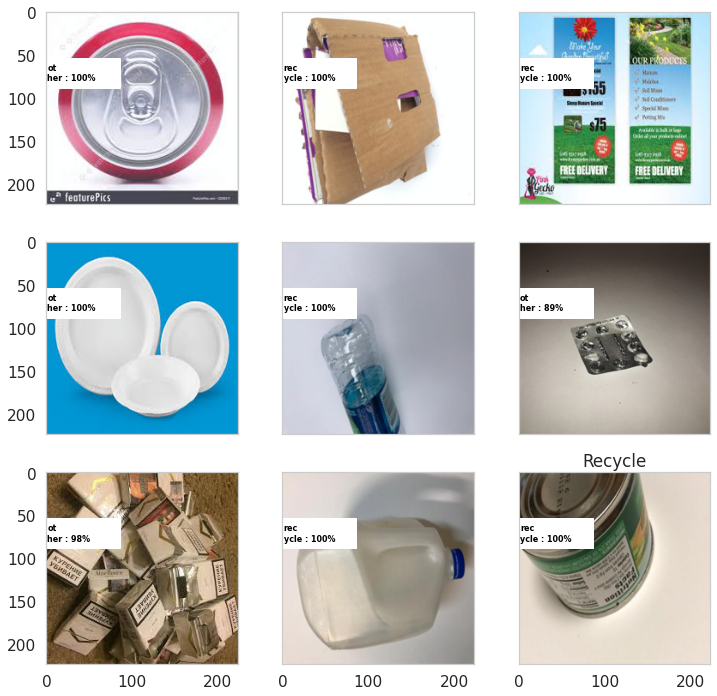

In [45]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_2, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [47]:
test_dataset = WasteDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_2, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [48]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('my_resnet_1_submit.csv', index=False)
my_submit.head()

,Id,Expected
0,Organic_0.jpg,other
1,Organic_1.jpg,other
2,Organic_10.jpg,organic
3,Organic_100.jpg,recycle
4,Organic_1000.jpg,organic


In [49]:
from sklearn.metrics import accuracy_score

def csv_acc(csv_file):
  y_pred = []
  y_real = []
  submit = pd.read_csv(csv_file)
  for id, img_label in enumerate(submit['Id']):
    y_real.append(img_label.split('_')[0])
    y_pred.append(submit['Expected'][id])
  print(f'Accuracy: {accuracy_score(y_real, y_pred)}')

In [51]:
csv_acc('./my_resnet_1_submit.csv')

Accuracy: 0.0057251908396946565


Test old pth with best weigths

In [52]:
from torch.autograd import Variable
import torch.onnx

PATH =os.path.join('./', "my_resnet_1.onnx")
dummy_input = Variable(torch.randn(1, 3, 224, 224)).to(DEVICE)
torch.onnx.export(model_2, dummy_input, PATH)